In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import json

In [2]:
conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,13677,19100,25489,33276,43847,53740,65778,83836,101657,121478
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,41035,47021,53578,59138,63927,69176,74386,80589,86498,92472
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,17963,20410,25374,28768,35136,39885,49515,57786,65719,73235
62,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67800,67800,67800,67800,67800,67801,67801,67801,67801,67801
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,15320,19848,22213,24873,29056,32986,37323,43938,50871,57695
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,10871,12612,14282,16018,19856,22304,25233,29155,32964,37575
133,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,18407,19644,20610,21638,23049,24811,27017,29406,32332,35408
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,2689,3983,5018,5683,6650,8077,9529,11658,14543,17089
206,NaN,Switzerland,46.8182,8.2275,0,0,0,0,0,0,...,4075,5294,6575,7474,8795,9877,10897,11811,12928,14076
169,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,...,2460,2994,3631,4204,4749,5560,6412,7431,8603,9762


In [3]:
for c in list(conf['Country/Region'].unique()):
    print(c)

US
Italy
Spain
China
Germany
France
Iran
United Kingdom
Switzerland
Netherlands
Korea, South
Belgium
Austria
Turkey
Portugal
Norway
Brazil
Israel
Sweden
Czechia
Canada
Ireland
Malaysia
Denmark
Chile
Luxembourg
Ecuador
Japan
Poland
Australia
Pakistan
Romania
Russia
Thailand
Saudi Arabia
South Africa
Finland
Indonesia
Philippines
Greece
India
Iceland
Singapore
Panama
Dominican Republic
Mexico
Diamond Princess
Argentina
Slovenia
Peru
Serbia
Croatia
Estonia
Colombia
Qatar
Egypt
Iraq
Bahrain
United Arab Emirates
Algeria
New Zealand
Lebanon
Armenia
Morocco
Lithuania
Ukraine
Hungary
Bulgaria
Andorra
Latvia
Costa Rica
Slovakia
Taiwan*
Tunisia
Uruguay
Bosnia and Herzegovina
Jordan
North Macedonia
Kuwait
Moldova
Kazakhstan
San Marino
Burkina Faso
Albania
Azerbaijan
Cyprus
Vietnam
Oman
Malta
Ghana
Senegal
Brunei
Cuba
Venezuela
Sri Lanka
Afghanistan
Uzbekistan
Mauritius
Cote d'Ivoire
Cambodia
West Bank and Gaza
Honduras
Belarus
Kosovo
Cameroon
Georgia
Nigeria
Montenegro
Trinidad and Tobago
Bolivia

In [4]:
# Combine rows that correspond to the same country but different state/province

conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.drop(columns=['Province/State'], inplace=True)
cols = list(conf.columns.values)
vals = []
dates = []
for col in cols:
    if col[0].isdigit():
        dates.append(col)
        vals.append('sum')
    else:
        vals.append('first')
agg = dict(zip(cols, vals))
conf_combined = conf.groupby(conf['Country/Region']).aggregate(agg)
conf_combined = conf_combined.sort_values(conf_combined.columns[-1], ascending=False)

In [5]:
deaths = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths = deaths.sort_values(conf.columns[-1], ascending=False)
deaths.drop(columns=['Province/State'], inplace=True)
cols = list(deaths.columns.values)
vals = []
dates = []
for col in cols:
    if col[0].isdigit():
        dates.append(col)
        vals.append('sum')
    else:
        vals.append('first')
agg = dict(zip(cols, vals))
death_combined = deaths.groupby(conf['Country/Region']).aggregate(agg)
#death_combined = death_combined.sort_values(conf_combined.columns[-1], ascending=False)
death_combined = death_combined.reindex(conf_combined.index)

In [6]:
test = conf_combined.drop(['Country/Region', 'Lat', 'Long'], axis=1)
test.index
test.iloc[0,:]

1/22/20         1
1/23/20         1
1/24/20         2
1/25/20         2
1/26/20         5
            ...  
3/24/20     53740
3/25/20     65778
3/26/20     83836
3/27/20    101657
3/28/20    121478
Name: US, Length: 67, dtype: int64

In [7]:
"""Normalized growth rate

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing beween data points
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect
    
Returns 
-------
float
    1D array of growth rates'"""
def growth(arr, dx, padding='Same'):
    d = [None] * len(arr)
    for i in range(1, len(arr)-1):
        d[i] = (arr[i] - arr[i-1]) / dx
    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    elif padding is 'Reflect':
        d[0] = d[-1]
        d[-1] = d[0]
    return d

"""2nd derivative finite difference (https://en.wikipedia.org/wiki/Five-point_stencil)

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing between data points (must be constant)
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect'
stencil_size : int
    size of stencil
    Option: 3, 5
    
Returns
-------
float
    1D array of finite differences
"""
def fd_2(arr, dx, padding='Same', stencil_size=3):
    d = [None] * len(arr)
    if stencil_size is 3:
        for i in range(1, len(arr)-1):
            d[i] = (arr[i-1] - 2*arr[i] + arr[i+1]) / dx
    elif stencil_size is 5:
        d[1] = (arr[0] - 2*arr[1] + arr[2]) / dx
        d[-2] = (arr[-3] - 2*arr[-2] + arr[-1]) / dx
        for i in range(2, len(arr) - 2):
            d[i] = (-arr[i-2] + 16*arr[i-1] - 30*arr[i] + 16*arr[i+1] - arr[i+2]) / 12

    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    elif padding is 'Reflect':
        d[0] = d[-1]
        d[-1] = d[0]
    return d

In [8]:
def plotn(dates, df, delta_x, num_countries=1, title='Untitled', date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    legend = df['Country/Region']
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    if mode is 'num_cases':
        for i in range(num_countries):
            plt.plot(x[dr[0]:dr[1]], df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[dr[0]:dr[1],i], label=legend[i])
    elif mode is 'growth':
        for i in range(num_countries):
            g = growth(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=legend[i])
    elif mode is 'deriv2':
        for i in range(num_countries):
            d = fd_2(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=legend[i])
    plt.legend(loc='lower right', bbox_to_anchor=(1.4,0))
    plt.title(title)
    plt.gcf().autofmt_xdate()
    
def plotc(dates, df, delta_x, countries=['US'], title='Untitled', date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    if mode is 'num_cases':
        for c in countries:
            plt.plot(x[dr[0]:dr[1]], df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c][dr[0]:dr[1]], label=c)
    elif mode is 'growth':
        for c in countries:
            g = growth(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=c)
    elif mode is 'deriv2':
        for c in countries:
            d = fd_2(list(df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), delta_x, 'Same', 3)
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=c)
    plt.legend(loc='lower right', bbox_to_anchor=(1.4,0))
    plt.title(title)
    plt.gcf().autofmt_xdate()

In [9]:
def create_json(df_orig, title, delta_x=1):
    df = df_orig.drop(['Country/Region', 'Lat', 'Long'], axis=1)
    df_temp = df.copy()
    
    j_num_cases = df.to_json(orient='index')
    for i in range(len(df.index)):
        df_temp.iloc[i,:] = growth(list(df.iloc[i,:]), delta_x, 'Same')
    j_growth = df_temp.to_json(orient='index')
    for i in range(len(df.index)):
        df_temp.iloc[i,:] = fd_2(list(df.iloc[i,:]), delta_x, 'Same', 3)
    j_deriv2 = df_temp.to_json(orient='index')
    
    with open('{}_num_cases.json'.format(title), 'w') as f:
        json.dump(j_num_cases, f)
    with open('{}_growth.json'.format(title), 'w') as f:
        json.dump(j_growth, f)
    with open('{}_deriv2.json'.format(title), 'w') as f:
        json.dump(j_deriv2, f)

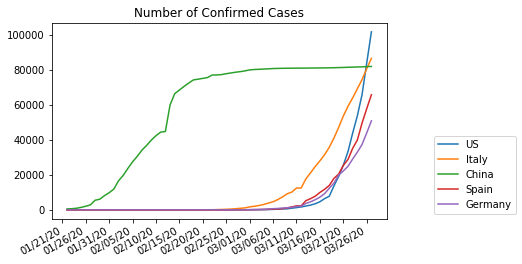

In [10]:
plotn(dates, conf_combined, 1, 5, mode='num_cases', title='Number of Confirmed Cases')

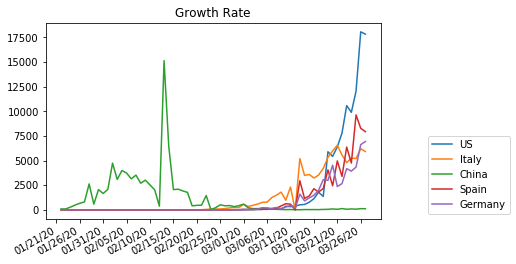

In [11]:
plotn(dates, conf_combined, 1, 5, title='Growth Rate', mode='growth')

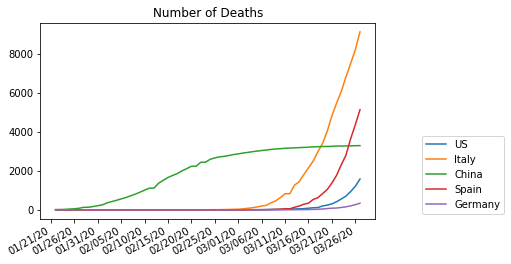

In [12]:
plotn(dates, death_combined, 1, 5, mode='num_cases', title='Number of Deaths')

In [13]:
mort = death_combined.copy()
mort.iloc[:,3:] = (mort.iloc[:,3:]/conf_combined.iloc[:,3:]).replace([np.inf, np.nan], 0)
mort.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
US,US,37.0902,-95.7129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014623,0.012775,0.012044,0.012532,0.012703,0.013137,0.014321,0.014421,0.015552,0.016678
Italy,Italy,43.0000,12.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.082978,0.085749,0.090056,0.092597,0.095062,0.098589,0.100866,0.101937,0.105598,0.108390
China,China,30.9756,112.2707,0.031022,0.027994,0.028261,0.029872,0.026988,0.028502,0.023779,...,0.040034,0.040037,0.040084,0.040204,0.040173,0.040213,0.040227,0.040241,0.040246,0.040232
Spain,Spain,40.0000,-4.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.046206,0.051102,0.054189,0.061596,0.065773,0.070402,0.073654,0.075537,0.078181,0.081682
Germany,Germany,51.0000,9.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002872,0.003376,0.003782,0.003779,0.004233,0.004760,0.005519,0.006077,0.006723,0.007505


In [14]:
# Have to convert to numpy arrays here since pandas isn't dividing as expected

T = 7
mort2 = death_combined.iloc[:,np.r_[0:3,(3+T):len(death_combined.columns)]].copy() #Skip first T days
arr1 = mort2.iloc[:,3:].to_numpy()
arr2 = conf_combined.iloc[:,3:-T].to_numpy()
q = arr1/arr2
mort2.iloc[:,3:] = q
mort2.replace([np.inf, np.nan], 0)
mort2.head()

/usr/local/Caskroom/miniconda/base/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/Caskroom/miniconda/base/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


,Country/Region,Lat,Long,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
US,US,37.0902,-95.7129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.120265,0.111978,0.112578,0.119177,0.120250,0.109952,0.121033,0.088397,0.082775,0.079485
Italy,Italy,43.0000,12.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.273231,0.228313,0.228057,0.221279,0.217191,0.216467,0.210092,0.200195,0.194254,0.187073
China,China,30.9756,112.2707,0.242701,0.265941,0.231522,0.184211,0.173976,0.147723,0.089127,...,0.040145,0.040188,0.040246,0.040418,0.040403,0.040477,0.040505,0.040552,0.040566,0.040576
Spain,Spain,40.0000,-4.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.364515,0.199350,0.215146,0.227238,0.232448,0.239019,0.262185,0.242999,0.251739,0.235753
Germany,Germany,51.0000,9.0000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,...,0.021174,0.018231,0.018321,0.016221,0.016914,0.016960,0.016711,0.017428,0.017231,0.019493


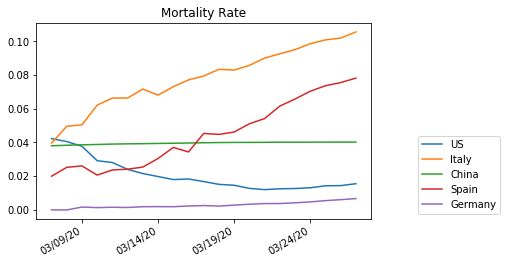

In [15]:
plotn(dates, mort, 1, 5, title='Mortality Rate', date_range=[-22,-1])

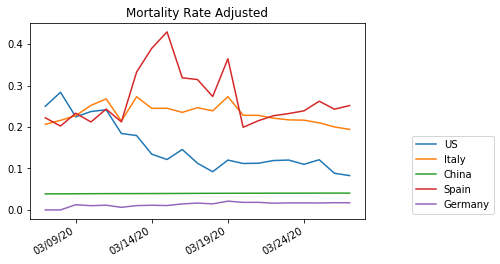

In [16]:
plotn(dates, mort2, 1, 5, title='Mortality Rate Adjusted', date_range=[-22,-1])

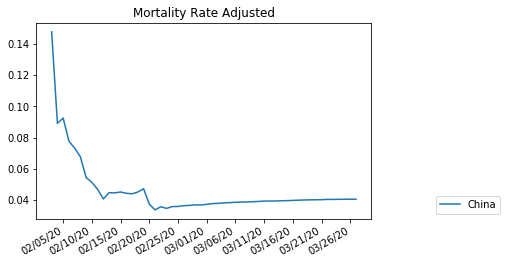

In [17]:
plotc(dates=dates, df=mort2, delta_x=1, countries=['China'], title='Mortality Rate Adjusted', date_range=[-55,-1])

In [50]:
create_json(conf_combined, 'confirmed')

In [43]:
test = conf_combined.drop(['Country/Region', 'Lat', 'Long'], axis=1)
len(list(test.iloc[0,:]))

64

In [46]:
len(growth(list(test.iloc[0,:]), dx=1))

64

In [44]:
len(test.index)

174

In [42]:
test.iloc[0,:] = growth(list(test.iloc[0,:]), dx=1)